# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import svd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# PATH_TO_DATA = "/content/drive/My Drive/MVA/Deep_Learning/nlp_project/data/"
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = {v:i for i, v in enumerate(self.word2vec.keys())}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = list(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
        scores = {v:self.score(w, v) for v in self.word2vec.keys()}
        scores = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)
        scores = scores[:K]
        
        return [d[0] for d in scores]

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        w1_vec, w2_vec = self.word2vec[w1], self.word2vec[w2]
        return np.dot(w1_vec, w2_vec)/(np.linalg.norm(w1_vec)*np.linalg.norm(w2_vec))


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=55000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 55000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'Dog', 'doggie']
['dogs', 'dog', 'Dogs', 'doggies', 'canines']
['paris', 'france', 'Paris', 'london', 'berlin']
['germany', 'europe', 'german', 'berlin', 'france']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        sentemb = []
        for sent in sentences:
#             sent = sent[:-2].split(' ')
            sent = sent.replace('\n', '').split(' ')
            if not idf:
                # mean of word vectors
                sentemb.append(np.nanmean([self.w2v.word2vec.get(v, np.full(300, np.nan)) for v in sent], axis = 0))
                
            else:
                # idf-weighted mean of word vectors
                sentemb.append(np.nanmean([self.idf[v]*self.w2v.word2vec.get(v, np.full(300, np.nan)) for v in sent], axis = 0))
                
        return sentemb

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        scores = [self.score(s, sent, idf) for sent in sentences]
        indices = np.argsort(scores)[::-1]
        s = [sentences[indices[i + 1]] for i in range(K)]
        for x in s:
          print(x)
          
        return s

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        s1_encoding, s2_encoding = self.encode([s1], idf)[0], self.encode([s2], idf)[0]
        return np.dot(s1_encoding, s2_encoding)/(np.linalg.norm(s1_encoding)*np.linalg.norm(s2_encoding))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
          for w in sent.replace('\n', '').split(' '):
            idf[w] = idf.get(w, 0) + 1
            
        for w in idf:
          idf[w] = max(1, np.log10(len(sentences) / idf[w]))
          self.idf = idf

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=50000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with open(os.path.join(PATH_TO_DATA, 'sentences.txt')) as f:
  sentences = f.readlines()
        
# Build idf scores for each word
s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print('Without idf, the 5 most similar sentences to : ' + sentences[10].replace('\n', ''))
s2v.most_similar(sentences[10], sentences)  # BoV-mean
print('Without idf, the cosine similarity : %.4f' %s2v.score(sentences[7], sentences[13]))

print('With idf, the 5 most similar sentences to : ' + sentences[10].replace('\n', ''))
s2v.most_similar(sentences[10], sentences, True)  # BoV-idf
print('With idf, the cosine similarity : %.4f' %s2v.score(sentences[7], sentences[13], True))

Loaded 50000 pretrained word vectors
Without idf, the 5 most similar sentences to : 1 smiling african american boy . 
an african american man smiling . 

a little african american boy and girl looking up . 

an african american in sunglasses and a white tee-shirt smiles . 

an afican american woman standing behind two small african american children . 

an african american man is sitting . 

Without idf, the cosine similarity : 0.5726
With idf, the 5 most similar sentences to : 1 smiling african american boy . 
an african american man smiling . 

an african american man is sitting . 

a little african american boy and girl looking up . 

an afican american woman standing behind two small african american children . 

an african american woman braiding another african american woman 's hair , while sitting in a white chair . 

With idf, the cosine similarity : 0.4751


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE

!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

w2v_en = Word2vec('wiki.en.vec', nmax=50000)
w2v_fr = Word2vec('wiki.fr.vec', nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE

words_common = set(w2v_en.word2vec.keys()).intersection(set(w2v_fr.word2vec.keys()))
X = np.array([w2v_fr.word2vec[word] for word in words_common])
Y = np.array([w2v_en.word2vec[word] for word in words_common])

In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
U, s, Vh = scipy.linalg.svd(np.dot(Y.T, X))
W = np.dot(U, Vh)

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE

class Multilingual:
    
    def __init__(self, w2v_fr, w2v_en):
        
        """
        Description
        -------------
        Constructor of class Multilingual
        
        Attributes
        -------------
        w2v_fr       : Word2vec object, french words embeddings.
        w2v_en       : Word2vec object, english words embeddings.
        words_common : Set of strings, the common words between French and English.
        X            : np.array of shape (len(words_common), 300), embeddings of French common words.
        Y            : np.array of shape (len(words_common), 300), embeddings of English common words.
        
        Returns
        -------------
        """
        
        self.w2v_fr = w2v_fr
        self.w2v_en = w2v_en
        
        self.words_common = set(self.w2v_en.word2vec.keys()).intersection(set(self.w2v_fr.word2vec.keys()))
        self.X = np.array([self.w2v_fr.word2vec[word] for word in self.words_common])
        self.Y = np.array([self.w2v_en.word2vec[word] for word in self.words_common])
        
        U, _, Vh = scipy.linalg.svd(np.dot(self.Y.T, self.X))
        W = np.dot(U, Vh)

    def score(self, w1, w2, language):

        """
        Description
        -------------
        Cosine similarity between the transformation of w1 (French --> English and vice-versa) and w2.

        Parameters
        -------------
        w1        : String, word in language.
        w2        : String, word in a different language than w1.
        language  : String in {'fr', 'en'}, language of w1.

        Returns
        -------------
        Float, the cosine similarity of the transformation of w1 and w2.
        """

        if language == 'fr':
            w1_vec, w2_vec = w2v_fr.word2vec[w1], w2v_en.word2vec[w2]
            w1_vec = np.dot(W, w1_vec)
            
        else:
            w1_vec, w2_vec = w2v_en.word2vec[w1], w2v_fr.word2vec[w2]
            w1_vec = np.dot(W.T, w1_vec)

        return np.dot(w1_vec, w2_vec)/(np.linalg.norm(w1_vec)*np.linalg.norm(w2_vec))

    def nearest(self, w, language, K = 5):

        """
        Description
        -------------
        Give K nearest to word w (in French) in English

        Parameters
        -------------
        w         : String, word in French.
        language  : String in {'fr', 'en'}, language of w.
        K         : Int, number of neighbors we want (default = 5).

        Returns
        -------------
        List of the K nearest neighbors to word w.
        """
        
        if language == 'fr':
            scores = {v:self.score(w, v, 'fr') for v in w2v_en.word2vec.keys()}
            scores = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)
            scores = scores[:K]
            
        else:
            scores = {v:self.score(w, v, 'en') for v in w2v_fr.word2vec.keys()}
            scores = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)
            scores = scores[:K]

        return [d[0] for d in scores]
    
multi = Multilingual(w2v_fr, w2v_en)
print('5 Nearest neighbors to word bananas in French', multi.nearest('banana', 'en', K=5))
print('5 Nearest neighbors to word university in French', multi.nearest('university', 'en', K=5))
print('5 Nearest neighbors to word fire in French', multi.nearest('fire', 'en', K=5))
print('5 Nearest neighbors to word lumière in English', multi.nearest('lumière', 'fr', K=5))
print('5 Nearest neighbors to word hiver in English', multi.nearest('hiver', 'fr', K=5))
print('5 Nearest neighbors to word forêt in English', multi.nearest('forêt', 'fr', K=5))

5 Nearest neighbors to word bananas in French ['bananes', 'banane', 'ananas', 'banana', 'haricots']
5 Nearest neighbors to word university in French ['université', 'university', 'harvard', 'princeton', 'faculty']
5 Nearest neighbors to word fire in French ['fire', 'feu', 'incendie', 'flammes', 'incendies']
5 Nearest neighbors to word lumière in English ['lumière', 'luminous', 'wavelengths', 'illumination', 'brightness']
5 Nearest neighbors to word hiver in English ['winter', 'summer', 'alpine', 'olympics', 'skiing']
5 Nearest neighbors to word forêt in English ['forest', 'forests', 'wooded', 'forêt', 'heathland']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE

def load_train_dev(path):
    
    """
    Description
    -------------
    Load the train or dev data.
    
    Parameters
    -------------
    path : String, path to the train or dev data.
    
    Returns
    -------------
    X : List of strings containing the sentences.
    Y : np.array of shape (number_sentences,) and dtype Int containing the labels
    """
    
    with open(path) as f:
        sentences = f.readlines()
    
    X = []
    Y = np.zeros(len(sentences))
    for i in range(len(sentences)):
        sent = sentences[i]
        Y[i] = int(sent[0])
        X.append(sent[2:])
        
    return X, Y

def load_test(path):
    
    """
    Description
    -------------
    Load the training data.
    
    Parameters
    -------------
    path : String, path to the training data.
    
    Returns
    -------------
    X : List of strings containing the sentences.
    Y : np.array of shape (number_sentences,) and dtype Int containing the labels
    """
    
    with open(path) as f:
        sentences = f.readlines()
    
    X = []
    for sent in sentences:
        X.append(sent[2:])
        
    return X

X, Y = load_train_dev(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
X_dev, Y_dev = load_train_dev(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
X_test = load_test(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'))

In [16]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
s2v = BoV(w2v)

# Build idf scores for each word
s2v.build_idf(X + X_dev + X_test)

# Encoding without idf
X_embedding = s2v.encode(X)
X_embedding_dev = s2v.encode(X_dev)
X_embedding_test = s2v.encode(X_test)

# Encoding with idf
X_embedding_idf = s2v.encode(X, True)
X_embedding_dev_idf = s2v.encode(X_dev, True)
X_embedding_test_idf = s2v.encode(X_test, True)

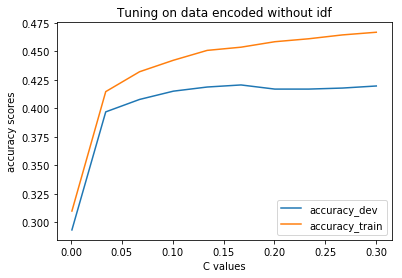

Tuning C, we get for C = 0.167 , accuracy = 0.4205 


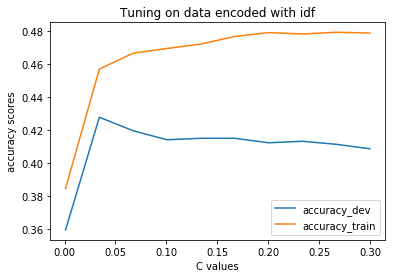

Tuning C, we get for C = 0.034 , accuracy = 0.4278 


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# By default (C=1) the logistic regression model does not generalize well to the
# dev set, that's why we look for optimal C value in ranges that are inferior
# to 1.


def tune_and_evaluate(data_train, pred_train, data_dev, pred_dev, interval = [1e-3, 0.3], num_points = 10, title = ''):
    
    """
    Description
    --------------
    Tune a logistic regression model on our data in order to select the best model. (The tuning is simplistic, it is done
    only on the regularization parameter C)
    
    Parameters
    --------------
    data_train : array-like, the training data.
    pred_train : array-like, the modeled variable on the training data.
    data_dev   : array-like, the dev data.
    pred_dev   : array-like, the modeled variable on the dev data.
    interval   : List of length 2, the range of tuning.
    num_points : Int, number of C values in interval to test.
    titles     : String, the plot title.
    
    Returns
    --------------
    The optimal C value.
    """
    
    C_values = np.linspace(interval[0], interval[1], num = num_points)
    accuracy_train = []
    accuracy_dev = []
    for C in C_values:
        clf = LogisticRegression(C=C, n_jobs = -1)
        clf.fit(data_train, pred_train)
        Y_dev_pred = clf.predict(data_dev)
        Y_pred = clf.predict(data_train)
        accuracy_dev.append(accuracy_score(pred_dev, Y_dev_pred))
        accuracy_train.append(accuracy_score(pred_train, Y_pred))

    plt.plot(C_values, accuracy_dev, label = 'accuracy_dev')
    plt.plot(C_values, accuracy_train, label = 'accuracy_train')
    plt.xlabel('C values')
    plt.ylabel('accuracy scores')
    plt.title(title)
    plt.legend()
    plt.show()

    C_max_arg = np.argmax(accuracy_dev) # The value of C maximizing the accuracy score on the dev set.
    C_opt = C_values[C_max_arg]

    clf = LogisticRegression(C=C_opt)
    clf.fit(data_train, Y)
    Y_dev_pred = clf.predict(data_dev)
    Y_pred = clf.predict(data_train)
    print('Tuning C, we get for C = %.3f , accuracy = %.4f ' %(C_opt, accuracy_score(Y_dev, Y_dev_pred)))
    return C_opt
    
C_without_idf = tune_and_evaluate(X_embedding, Y, X_embedding_dev, Y_dev, title = 'Tuning on data encoded without idf')
C_with_idf = tune_and_evaluate(X_embedding_idf, Y, X_embedding_dev_idf, Y_dev, title = 'Tuning on data encoded with idf')

In [18]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE

clf = LogisticRegression(C=C_without_idf) # We use the optimal C value of mean encoded data set since it yielded a similar behaviour between train and dev sets.
clf.fit(X_embedding + X_embedding_dev, np.hstack((Y, Y_dev))) # Fit on both training and dev sets.
Y_test_pred = clf.predict(X_embedding_test)

file = open('logreg_bov_y_test_sst.txt', 'w')
for y in (Y_test_pred.astype(int)).astype(str):
    file.write(y + '\n')
file.close()

In [97]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [14]:
import keras

Using TensorFlow backend.


In [17]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "data/"

# TYPE CODE HERE

X, Y = load_train_dev(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
X_dev, Y_dev = load_train_dev(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
X_test = load_test(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'))

print('Total number of words in the whole dataset : %d' %len(s2v.idf.keys())) # Use the previously built idf on the whole dataset.

Total number of words in the whole dataset : 19944


In [18]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing import text

X_integers = [text.one_hot(sent, n = 19944) for sent in X]
X_dev_integers = [text.one_hot(sent, n = 19944) for sent in X_dev]
X_test_integers = [text.one_hot(sent, n = 19944) for sent in X_test]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [19]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing import sequence
X_all_padded = sequence.pad_sequences(X_integers + X_dev_integers + X_test_integers)
X_padded, X_dev_padded, X_test_padded = X_all_padded[:len(X_integers)], X_all_padded[len(X_integers):len(X_integers) + len(X_dev_integers)], X_all_padded[len(X_integers) + len(X_dev_integers):len(X_integers) + len(X_dev_integers) + len(X_test_integers)]


## 4.2 - Design and train your model

In [20]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, SpatialDropout1D, Dropout

embed_dim  = 300  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 19944  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(nhid, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(n_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         5983200   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 300)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 6,076,965
Trainable params: 6,076,965
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
from keras.utils import to_categorical
bs = 256
n_epochs = 10
Y_categorical = to_categorical(Y, 5)
Y_dev_categorical = to_categorical(Y_dev, 5)

history = model.fit(X_padded, Y_categorical, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev_padded, Y_dev_categorical))

Instructions for updating:
Use tf.cast instead.
Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 9s 1ms/step - loss: 1.5906 - acc: 0.2611 - val_loss: 1.5714 - val_acc: 0.2589
Epoch 2/10
8544/8544 [==============================] - 7s 820us/step - loss: 1.5672 - acc: 0.2817 - val_loss: 1.5665 - val_acc: 0.2816
Epoch 3/10
8544/8544 [==============================] - 7s 793us/step - loss: 1.5543 - acc: 0.2933 - val_loss: 1.5606 - val_acc: 0.2725
Epoch 4/10
8544/8544 [==============================] - 7s 807us/step - loss: 1.5378 - acc: 0.3302 - val_loss: 1.5474 - val_acc: 0.3270
Epoch 5/10
8544/8544 [==============================] - 7s 797us/step - loss: 1.5038 - acc: 0.3454 - val_loss: 1.5164 - val_acc: 0.3279
Epoch 6/10
8544/8544 [==============================] - 7s 811us/step - loss: 1.4478 - acc: 0.3770 - val_loss: 1.4749 - val_acc: 0.3524
Epoch 7/10
8544/8544 [==============================] - 7s 789us/step - loss: 1.3653 - acc

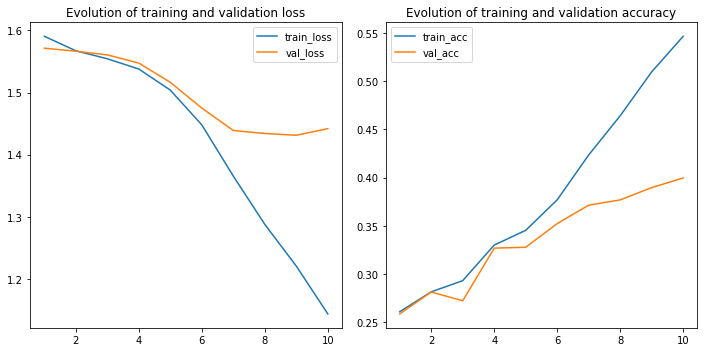

In [23]:
plt.figure(figsize = (10, 5))
plt.subplot(121)

plt.plot(range(1, n_epochs + 1), history.history['loss'], label = 'train_loss')
plt.plot(range(1, n_epochs + 1), history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.title('Evolution of training and validation loss')
# plt.show()

plt.subplot(122)

plt.plot(range(1, n_epochs + 1), history.history['acc'], label = 'train_acc')
plt.plot(range(1, n_epochs + 1), history.history['val_acc'], label = 'val_acc')
plt.legend()
plt.title('Evolution of training and validation accuracy')

plt.tight_layout()
plt.savefig('train_dev_results.png')
plt.show()

In [53]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
Y_test_pred = np.argmax(model.predict(X_test_padded), axis=1) + 1

file = open('logreg_lstm_y_test_sst.txt', 'w')
for y in (Y_test_pred.astype(int)).astype(str):
    file.write(y + '\n')
file.close()


## 4.3 -- innovate !

In [24]:
# We use the keras preprocessing function text_to_word_sequence to filter the unnecessary words '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
X_sequences = [text.text_to_word_sequence(sent) for sent in X]
X_dev_sequences = [text.text_to_word_sequence(sent) for sent in X_dev]
X_test_sequences = [text.text_to_word_sequence(sent) for sent in X_test]

dict_indices = {} # This dictionnary will map our relevant words to unique integers.
                  # We prefer this mapping to that of a hashing function to avoid any non unique potential mappings,
                  # plus we only need to index our words to build an embedding matrix that uses word2vec.

count = 0
for seq in (X_sequences + X_dev_sequences + X_test_sequences):
    for word in seq:
        if word not in dict_indices.keys():
            dict_indices[word] = count
            count += 1
            
def encode(sentence):
    """
    Encode sentence by replacing its words by their corresponding indexes in dict_indices dictionnary.
    """
    l = []
    for word in sentence:
        l.append(dict_indices[word])
        
    return l

X_encoded = [encode(sentence) for sentence in X_sequences]
X_dev_encoded = [encode(sentence) for sentence in X_dev_sequences]
X_test_encoded = [encode(sentence) for sentence in X_test_sequences]

X_all_padded = sequence.pad_sequences(X_encoded + X_dev_encoded + X_test_encoded)
X_padded, X_dev_padded, X_test_padded = X_all_padded[:len(X_encoded)], X_all_padded[len(X_encoded):len(X_encoded) + len(X_dev_encoded)], X_all_padded[len(X_encoded) + len(X_dev_encoded):len(X_encoded) + len(X_dev_encoded) + len(X_test_encoded)]
            
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000) # We take the maximum possible value of nmax to encode the maximum number of words possible in our dataset
print('There are still %d unencoded words' %len(set(dict_indices.keys()) - set(w2v.word2vec.keys())))
print('Examples of unencoded word : ', next(iter(set(dict_indices.keys()) - set(w2v.word2vec.keys()))))

dict_id2words = {v: k for k, v in dict_indices.items()}
embedding_matrix = np.empty((len(dict_indices.keys()), 300))
for i in range(len(dict_indices.keys())):
    embedding_matrix[i, :] = w2v.word2vec.get(dict_id2words[i], np.zeros(300))
    
    

Loaded 200000 pretrained word vectors
There are still 2530 unencoded words
Examples of unencoded word :  irly


Train on 8544 samples, validate on 1101 samples
Epoch 1/35
8544/8544 [==============================] - 8s 978us/step - loss: 1.5775 - acc: 0.2657 - val_loss: 1.5459 - val_acc: 0.3306
Epoch 2/35
8544/8544 [==============================] - 6s 692us/step - loss: 1.5309 - acc: 0.3179 - val_loss: 1.4520 - val_acc: 0.3551
Epoch 3/35
8544/8544 [==============================] - 6s 688us/step - loss: 1.4846 - acc: 0.3343 - val_loss: 1.4042 - val_acc: 0.3697
Epoch 4/35
8544/8544 [==============================] - 6s 688us/step - loss: 1.4564 - acc: 0.3543 - val_loss: 1.3667 - val_acc: 0.3960
Epoch 5/35
8544/8544 [==============================] - 6s 694us/step - loss: 1.4362 - acc: 0.3651 - val_loss: 1.3583 - val_acc: 0.3942
Epoch 6/35
8544/8544 [==============================] - 6s 685us/step - loss: 1.4280 - acc: 0.3732 - val_loss: 1.3423 - val_acc: 0.4033
Epoch 7/35
8544/8544 [==============================] - 6s 684us/step - loss: 1.4018 - acc: 0.3866 - val_loss: 1.3123 - val_acc: 0.4242


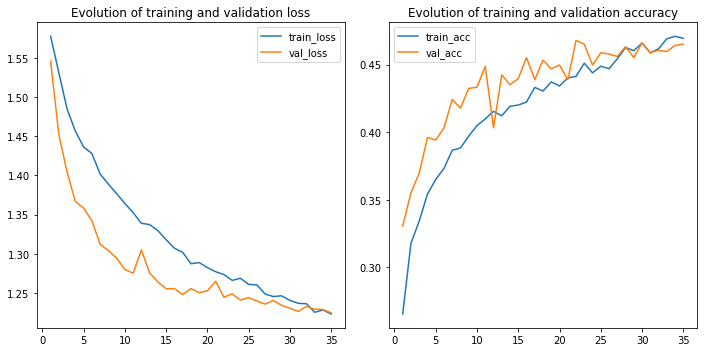

In [32]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

from keras import regularizers

embed_dim  = 300  # word embedding dimension
nhid       = 52  # number of hidden units in the LSTM
vocab_size = embedding_matrix.shape[0]  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim, trainable = False, weights = [embedding_matrix]))
# model.add(SpatialDropout1D(0.7))
model.add(LSTM(nhid, dropout=0.7, recurrent_dropout=0.7, recurrent_initializer = keras.initializers.Zeros()))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

bs = 128
n_epochs = 35
Y_categorical = to_categorical(Y, 5)
Y_dev_categorical = to_categorical(Y_dev, 5)

history = model.fit(X_padded, Y_categorical, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev_padded, Y_dev_categorical))

plt.figure(figsize = (10, 5))
plt.subplot(121)

plt.plot(range(1, n_epochs + 1), history.history['loss'], label = 'train_loss')
plt.plot(range(1, n_epochs + 1), history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.title('Evolution of training and validation loss')
# plt.show()

plt.subplot(122)

plt.plot(range(1, n_epochs + 1), history.history['acc'], label = 'train_acc')
plt.plot(range(1, n_epochs + 1), history.history['val_acc'], label = 'val_acc')
plt.legend()
plt.title('Evolution of training and validation accuracy')

plt.tight_layout()
plt.savefig('train_dev_results_lstm.png')
plt.show()

Y_test_pred = np.argmax(model.predict(X_test_padded), axis=1) + 1
file = open('fixembed_lstm_y_test_sst.txt', 'w')
for y in (Y_test_pred.astype(int)).astype(str):
    file.write(y + '\n')
file.close()




